In [1]:
import torch
import torch.distributions
import torch.nn as nn
import torch.nn.utils as utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# Layer

In [3]:
class CouplingLayer(nn.Module):
    def __init__(self, mask_type, input_channel):
        super(CouplingLayer, self).__init__()
        self.function_s_t = Function_s_t(input_channel)
        self.mask_type = mask_type
            
    def get_mask(self, num):
        ############################################
        # mask function 구현
        ############################################
        if '01' in self.mask_type:
            mask = torch.tensor([[0.0, 1.0]])
        else:
            mask = torch.tensor([[1.0, 0.0]])
            
        return mask
        
    def forward(self, x, reverse=False):
        
        if not reverse:
            # get mask
            mask = self.get_mask(self.mask_type)
            
            # masked half of x
            x1 = x * mask
            s,t = self.function_s_t(x1, mask)

            # z_1:d = x_1:d
            # z_d+1:D = exp(s(x_1:d)) * x_d+1:D + m(x_1:d)  
            y = x1 + ((-mask+1.0) * (x*torch.exp(s)+t))

            # calculation of jacobians
            log_det_jacobian = torch.sum(s, 1)
            
            return y, log_det_jacobian
        else:
            # get mask
            mask = self.get_mask(self.mask_type)

            # masked half of y
            x1 = x * mask
            s,t = self.function_s_t(x1, mask)
            
            # x_1:d = z_1:d
            # x_d+1:D = z_d+1:D - m(z_1:d) * exp(-s(z_1:d))
            y = x1 + (-mask+1.0) * ((x-t) * torch.exp(-s))

            return y

In [4]:
class Function_s_t(nn.Module):
    ############################################
    # scale, translation function 구현
    ############################################
    def __init__(self, input_channel, num_blocks=1, channel=256):
        super(Function_s_t, self).__init__()
        self.input_channel = input_channel
        layers = []

        layers += [
            nn.Linear(input_channel, channel),
            nn.LeakyReLU(),
            nn.Linear(channel, channel),
            nn.LeakyReLU(),
            nn.Linear(channel, input_channel*2)]
        
        self.model = nn.Sequential(*layers)
        self.w_scale = torch.rand(1, requires_grad=True)
    
    def forward(self, x, mask):
        x = self.model(x)
        
        #######################################
        # scale function : first half dimension
        # translation function : second half dimension
        #######################################
        s = x[:,:self.input_channel] * (-mask+1)
        t = x[:,self.input_channel:] * (-mask+1)
        
        s = nn.Tanh()(s)
        
        return s, t

# Model

In [7]:
class RealNVP(nn.Module):
    def __init__(self):
        super(RealNVP, self).__init__()
        layers = []
        
        self.num_scales = 2
        
   
        self.coupling_1 = CouplingLayer("01", 2)
        self.coupling_2 = CouplingLayer("10", 2)
        self.coupling_3 = CouplingLayer("01", 2)
        self.coupling_4 = CouplingLayer("10", 2)
        self.coupling_5 = CouplingLayer("01", 2)
        self.coupling_6 = CouplingLayer("10", 2)
        
        
        self.layers = nn.Sequential(*layers)       
            
    def forward(self, x, reverse=False):
        if not reverse:
            sum_log_det_jacobians = x.new_zeros(x.size(0))
            
            z, log_det_jacobians = self.coupling_1(x, reverse)
            sum_log_det_jacobians += log_det_jacobians
            
            z, log_det_jacobians = self.coupling_2(z, reverse)
            sum_log_det_jacobians += log_det_jacobians
            
            z, log_det_jacobians = self.coupling_3(z, reverse)
            sum_log_det_jacobians += log_det_jacobians
            
            z, log_det_jacobians = self.coupling_4(z, reverse)
            sum_log_det_jacobians += log_det_jacobians
            
            z, log_det_jacobians = self.coupling_5(z, reverse)
            sum_log_det_jacobians += log_det_jacobians
            
            z, log_det_jacobians = self.coupling_6(z, reverse)
            sum_log_det_jacobians += log_det_jacobians

            return z, sum_log_det_jacobians
        else:
            output = self.coupling_6(x, reverse)
            output = self.coupling_5(output, reverse)
            output = self.coupling_4(output, reverse)
            output = self.coupling_3(output, reverse)
            output = self.coupling_2(output, reverse)
            output = self.coupling_1(output, reverse)
            
            return output

In [8]:
model = RealNVP()

# Loss optimizor

In [9]:
class Loss(nn.Module):
    def __init__(self, prior):
        super(Loss, self).__init__()
        self.prior = prior
        
    def __call__(self, z, sum_log_det_jacobians):
        log_p = self.prior.log_prob(z)
        return -(log_p + sum_log_det_jacobians).mean()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
prior = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

In [12]:
loss_log_det_jacobians = Loss(prior)

# Data

### moon data

In [13]:
noisy_moons, label = datasets.make_moons(n_samples=1000, noise=0.05)

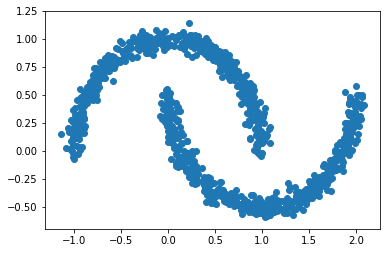

In [14]:
plt.scatter(noisy_moons[:,0], noisy_moons[:,1])

### normal distribution

In [15]:
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)

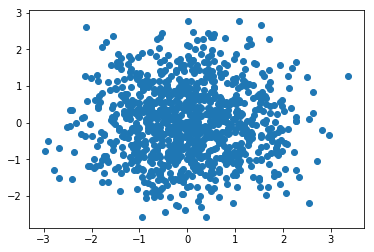

In [16]:
plt.scatter(z[:,0], z[:,1])

# Train

In [17]:
epochs = 1000

(epoch 0/1000) loss : 2.588


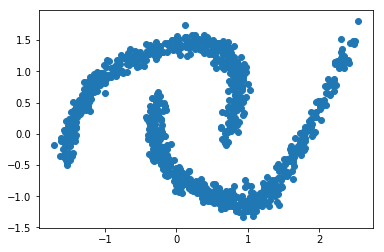

(epoch 200/1000) loss : 0.495


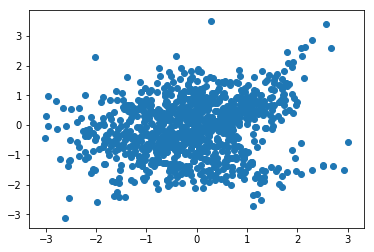

(epoch 400/1000) loss : 0.403


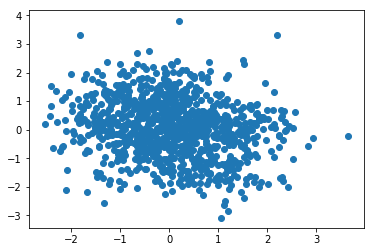

(epoch 600/1000) loss : 0.411


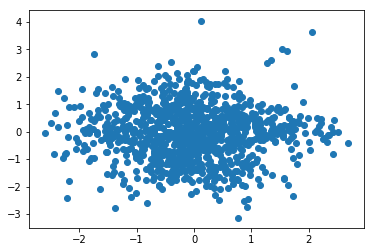

(epoch 800/1000) loss : 0.391


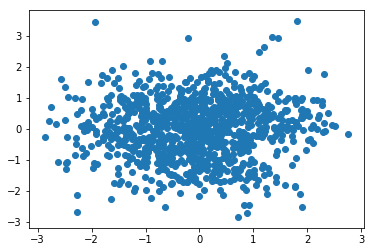

In [18]:
for epoch in range(epochs):
    model.train()
    x = datasets.make_moons(n_samples=1000, noise=0.05)[0].astype(np.float32)
    
    
    z, sum_log_det_jacobian = model(torch.from_numpy(x))
    loss = loss_log_det_jacobians(z, sum_log_det_jacobian)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print('(epoch %s/%s) loss : %.3f' % (epoch, epochs, loss.item()))
        # test
        model.eval()

        z, _ = model(torch.from_numpy(noisy_moons.astype(np.float32)))
        z = z.detach().numpy()
        plt.scatter(z[:,0], z[:,1])

        plt.show()

# Test

In [19]:
model.eval()
print('')

## Inference (X -> z)

### X data 

In [20]:
x, label = datasets.make_moons(n_samples=1000, noise=.05)
x = x.astype(np.float32)

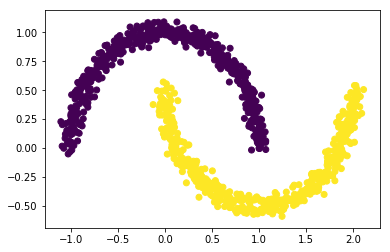

In [21]:
plt.scatter(x[:,0], x[:,1], c=label)

## z data

In [22]:
z, _ = model(torch.from_numpy(x))

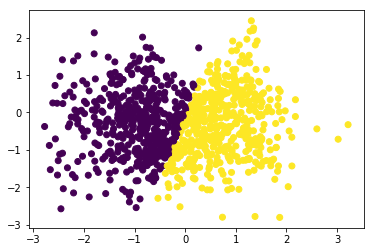

In [23]:
z = z.detach().numpy()
plt.scatter(z[:,0], z[:,1], c=label)

## Generate (z -> X)

### z data

In [24]:
z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000).astype(np.float32)

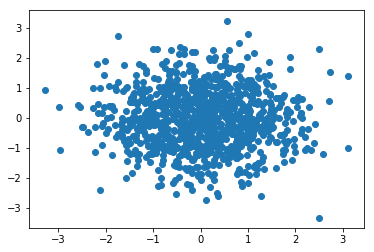

In [25]:
plt.scatter(z[:,0], z[:,1])

### x data

In [26]:
x = model(torch.from_numpy(z), reverse=True)

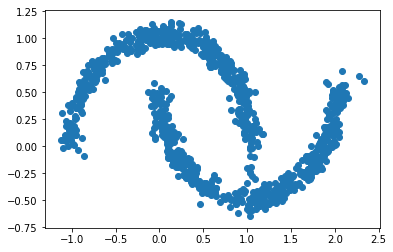

In [27]:
x = x.detach().numpy()
plt.scatter(x[:,0], x[:,1])